# This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the period that we are predicting for.

## Update the John Hopkins, Covid-19 data 
https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [27]:
# import libraries

# local function calls
import arima_grid_search as ags
import load_data as ld
import multi_step_forecast as msf
import stationarity as st
import summarize
import test_prediction_save_forecast_1day as tpsf1

# Standard libararies
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import warnings
warnings.filterwarnings("ignore")

## Prepare arguments for driver

In [28]:
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'D:\OneDrive\Documents\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'USA',
            'dependent_variable': 'Deaths',
            'path': r'D:\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (10,2,1), 
            'order_list': [],
            'p_values': range(1,8),
            'd_values': range(1,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '12-31-2021'}

## Load John Hopkins data

In [29]:
df, li_set = ld.driver(arg_dict)

# Get the date of the last file to establish the currency of the data.
# This is the only reason that I need df at this point.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

The "data date" is 2021-05-28 00:00:00



In [30]:
# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Test for stationarity

Empty DataFrame
Columns: [Deaths, Daily_Deaths]
Index: []
ADF Statistic: -2.344157
p-value: 0.158121
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


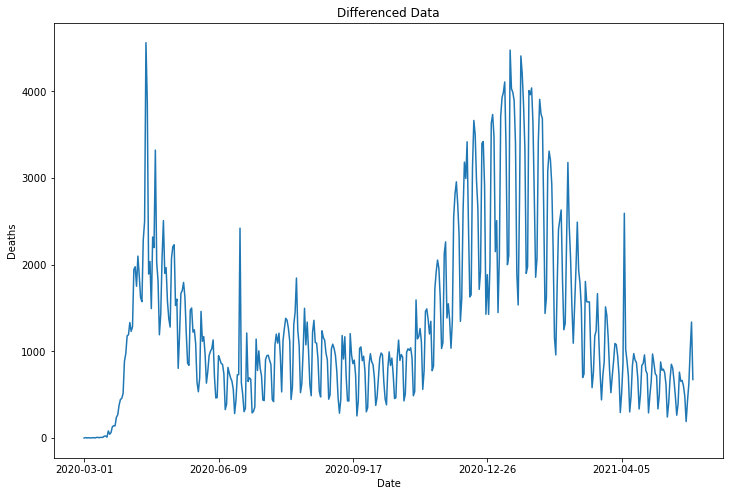

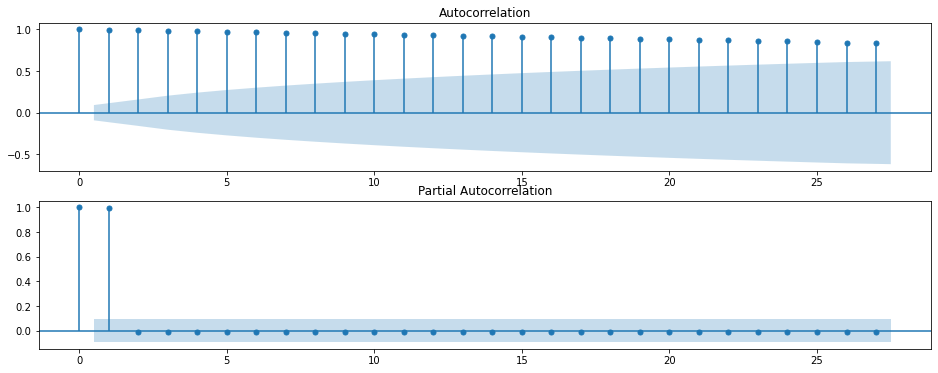

In [31]:
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')

## Grid search ARIMA parameters 

In [32]:
rmse_list = ags.driver(df, arg_dict)

# Create a df to display the rmse and pdq
rmse_order_df = pd.DataFrame({'RMSE': [x[0] for x in rmse_list], 'Order': [x[1] for x in rmse_list]})
rmse_order_df.head(10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  32 out of  42 | elapsed:   15.2s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  37 out of  42 | elapsed:   16.3s remaining:    2.1s



Best RMSE Score is 999999 with ARIMA of (1, 1, 0)


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   16.9s finished


,RMSE,Order
0,999999,"(1, 1, 0)"
1,999999,"(1, 1, 1)"
2,999999,"(1, 1, 2)"
3,999999,"(1, 2, 0)"
4,999999,"(1, 2, 1)"
5,999999,"(1, 2, 2)"
6,999999,"(2, 1, 0)"
7,999999,"(2, 1, 1)"
8,999999,"(2, 1, 2)"
9,999999,"(2, 2, 0)"


A RMSE of 999999 means that the fit/predict did not work for ARIMA

In [33]:
# We just need the order, not the RMSE
order_list = [item[1] for item in rmse_list]

arg_dict.update({'order_list': order_list})
arg_dict.update({'best_cfg': order_list[0]})

## Summarize residual errors for an ARIMA model and return bias


RMSE: 597.136
       Residual Statistics
count           228.000000
mean             86.552678
std             592.129953
min           -1443.220611
25%            -222.577041
50%              70.273626
75%             297.281737
max            2479.288717


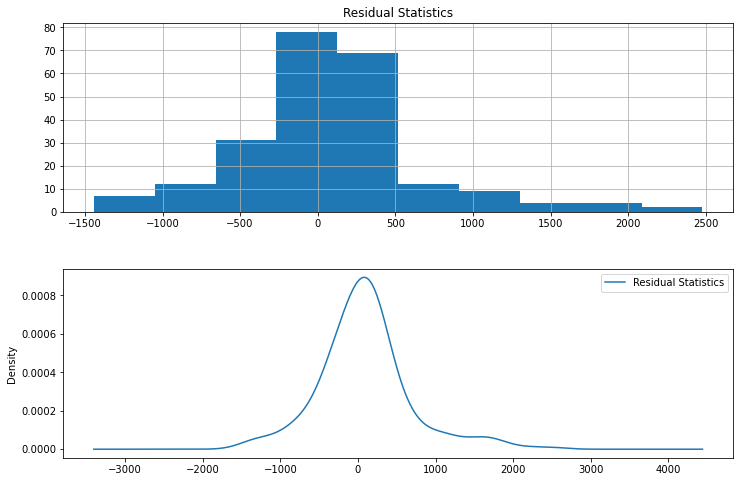


bias IS saved in arg_dict["bias"] for subsequent run is: 86.5526775428918 



In [ ]:
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Plot test (actual) vs predictions, save, and forecast

In [ ]:
tpsf1.driver(arg_dict)

NB The above prediction of a single day in the future will only rarely match the the first day in the multi step forecast below. The reason is that the ARIMA model is a moving average model. The specific days included in the moving average change in the multi step forecast. 

## Multi Step Forecast

In [ ]:
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

## Actual
If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to have no more instances by the date indicated. We truncate the prediction at that point. 

In [ ]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.tail(14) 

In [ ]:
# Graph a 7 day rolling average rate
df['moving_average'] = df[new_col].rolling(7).mean()
df.dropna(inplace=True)
df['moving_average'] = df['moving_average'].astype(np.int)
title = arg_dict['place'] + ' Historical 7 Day Moving Average of ' + new_col + ' for Covid-19'
plt.title(title)
plt.ylabel(new_col)
df['moving_average'].plot();

## 14 Day Forecast

In [ ]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head(14)

## Conclusions

- The code is quite flexible. It accepts any feature and will predict the values based on it. 

## Limitations

ARIMA is very sensitive to the most recent data. This is a feature of ARIMA models. This is probably not the best for long term predictions. However, it is also probably the best that we can do right now.